In [9]:

import pandas as pd
import numpy as np

# Data Collection

In [10]:
# !python ../scripts/generate_dataset.py --start_year 2007 --end_year 2022

# Data Loading

In [11]:
df = pd.read_csv("../data/exportacao_2007_2022.csv", sep=",", encoding="utf-8", thousands=".", na_values=["-"])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2048 entries, 0 to 2047
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Country      2048 non-null   object 
 1   Quantity     745 non-null    float64
 2   Value (US$)  745 non-null    float64
 3   Year         2048 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 64.1+ KB


In [13]:
df.head()

,Country,Quantity,Value (US$),Year
0,Afghanistan,NaN,NaN,2007
1,South Africa,NaN,NaN,2007
2,Germany,119512.0,238052.0,2007
3,Angola,25931.0,49753.0,2007
4,Anguilla,NaN,NaN,2007


## Data Cleaning

## Steps 
    1. Remove "Caribbean Netherlands" from dataset as was dissolved in 2010
    2. Generate Country Code
    3. Generate Continent
    4. Rename columns
    5. Remove NaN values
    6. if value is not 0 and quantity is 0, set quantity to mean
    7. Generate Value per Liter

In [14]:
# 1. Remove "Caribbean Netherlands" from dataset as was dissolved in 2010
df = df[df['Country'] != 'Caribbean Netherlands']

In [15]:
# 2. Generate Country Code
import pycountry


def get_country_code(country_name):
    try:
        return pycountry.countries.search_fuzzy(country_name)[0].alpha_2
    except:
        return np.nan


df['Country Code'] = df['Country'].apply(get_country_code)

In [16]:
# 3. Generate Continent
import pycountry_convert as pc


def get_continent_by_country_code(country_code):
    continent_name = {
        "NA": "North America",
        "SA": "South America",
        "AS": "Asia",
        "AF": "Africa",
        "OC": "Oceania",
        "EU": "Europe",
        "AQ": "Antarctica"
    }

    try:
        return continent_name.get(pc.country_alpha2_to_continent_code(country_code))
    except:
        return np.nan


df['Continent'] = df['Country Code'].apply(get_continent_by_country_code)

In [17]:
# 4. Rename columns
df.rename({
    "Year": "year",
    "Continent": "continent",
    "Country Code": "country_code",
    "Country": "country",
    "Quantity": "quantity",
    "Value (US$)": "value"
}, axis=1, inplace=True)
df = df[["year", "continent", "country_code", "country", "quantity", "value"]]

In [18]:
# 5. Remove NaN values
df.dropna(inplace=True)

In [19]:
# 6. if value is not 0 and quantity is 0, set quantity to mean
country = df.loc[(df['value'] != 0) & (df['quantity'] == 0)]['country'].to_list()
mean = df[df['country'] == country[0]]['quantity'].mean()
df.loc[(df['value'] != 0) & (df['quantity'] == 0), 'quantity'] = mean

In [20]:
# 7. Generate Value per Liter
df["value_x_liter"] = df["value"] / df["quantity"]

# Exploratory Data Analysis

## Steps on Sales Analysis
    1. Check sales per year
    2. Understand sales by continent over time
    3. check which countries we export by continent
    4. What is the percentage of total sales by continent

In [21]:
# https://worldpopulationreview.com/country-rankings/wine-consumption-by-country
# wine_consumption_per_country = pd.read_csv("../data/wine-consumption-by-country.csv", sep=",", encoding="utf-8")
# wine_consumption_per_country.sort_values(by="WineConsumptionPerCapita", ascending=False, inplace=True)
# wine_consumption_per_country.head(10)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Sales per year

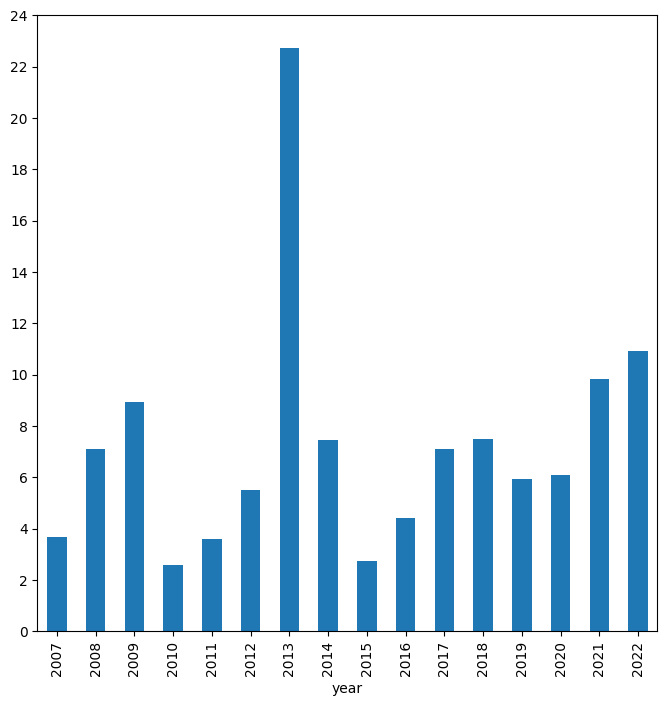

In [23]:
fig, ax = plt.subplots(figsize = (8, 8))
sales_by_year = df.groupby("year")["value"].sum() / 1000000
sales_by_year.plot(kind='bar')
ax.set_yticks(np.arange(0, 26, 2));

### 2. Sales by continent over time

In [24]:
sales_by_continent_year = df.groupby(["year", "continent"])["value"].sum() / 1000000
sales_by_continent_year = sales_by_continent_year.unstack().T

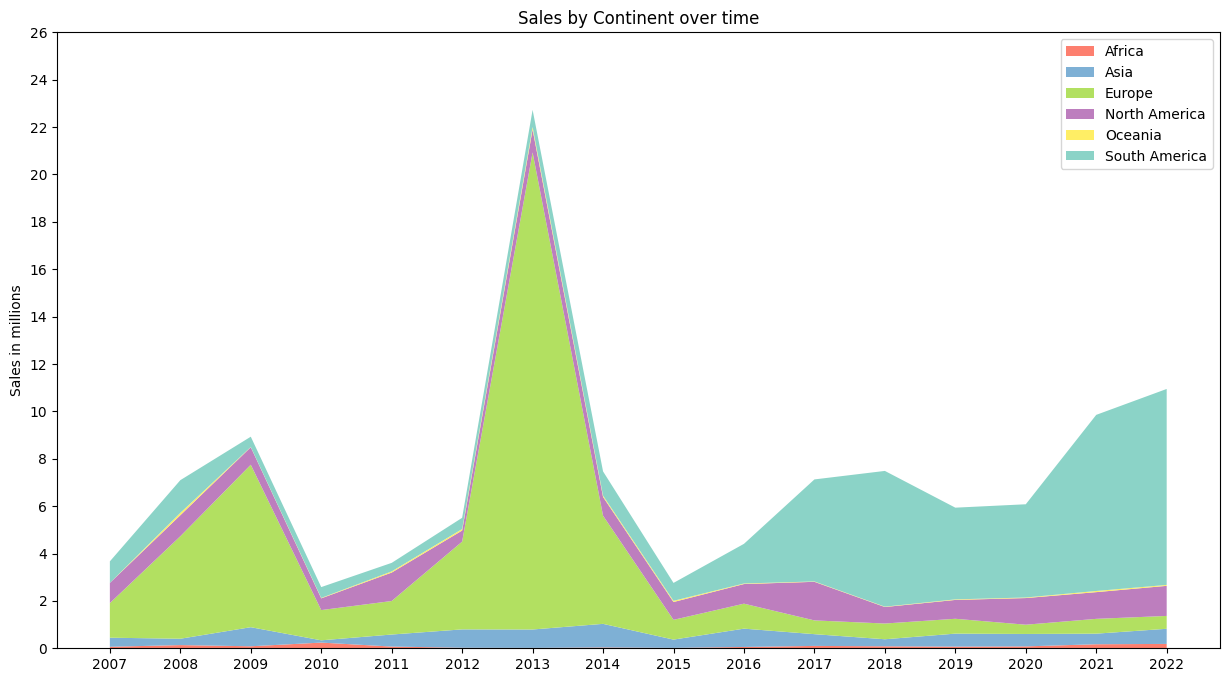

In [25]:
colors = {'Africa': "#fd7f6f", 'Asia': "#7eb0d5", 'Europe': "#b2e061", 'North America': "#bd7ebe", 'Oceania': "#ffee65", 'South America':  "#8bd3c7"}
fig, ax = plt.subplots(figsize = (15, 8))
ax.stackplot(sales_by_continent_year.columns, sales_by_continent_year.values, labels=sales_by_continent_year.index, colors=colors.values())
ax.set_title("Sales by Continent over time")
ax.set_xticks(df['year'].unique())
ax.set_yticks(np.arange(0, 28, 2))
ax.set_ylabel("Sales in millions")
ax.grid(False)
ax.legend(loc='upper right');

### 3. check which countries we export by continent

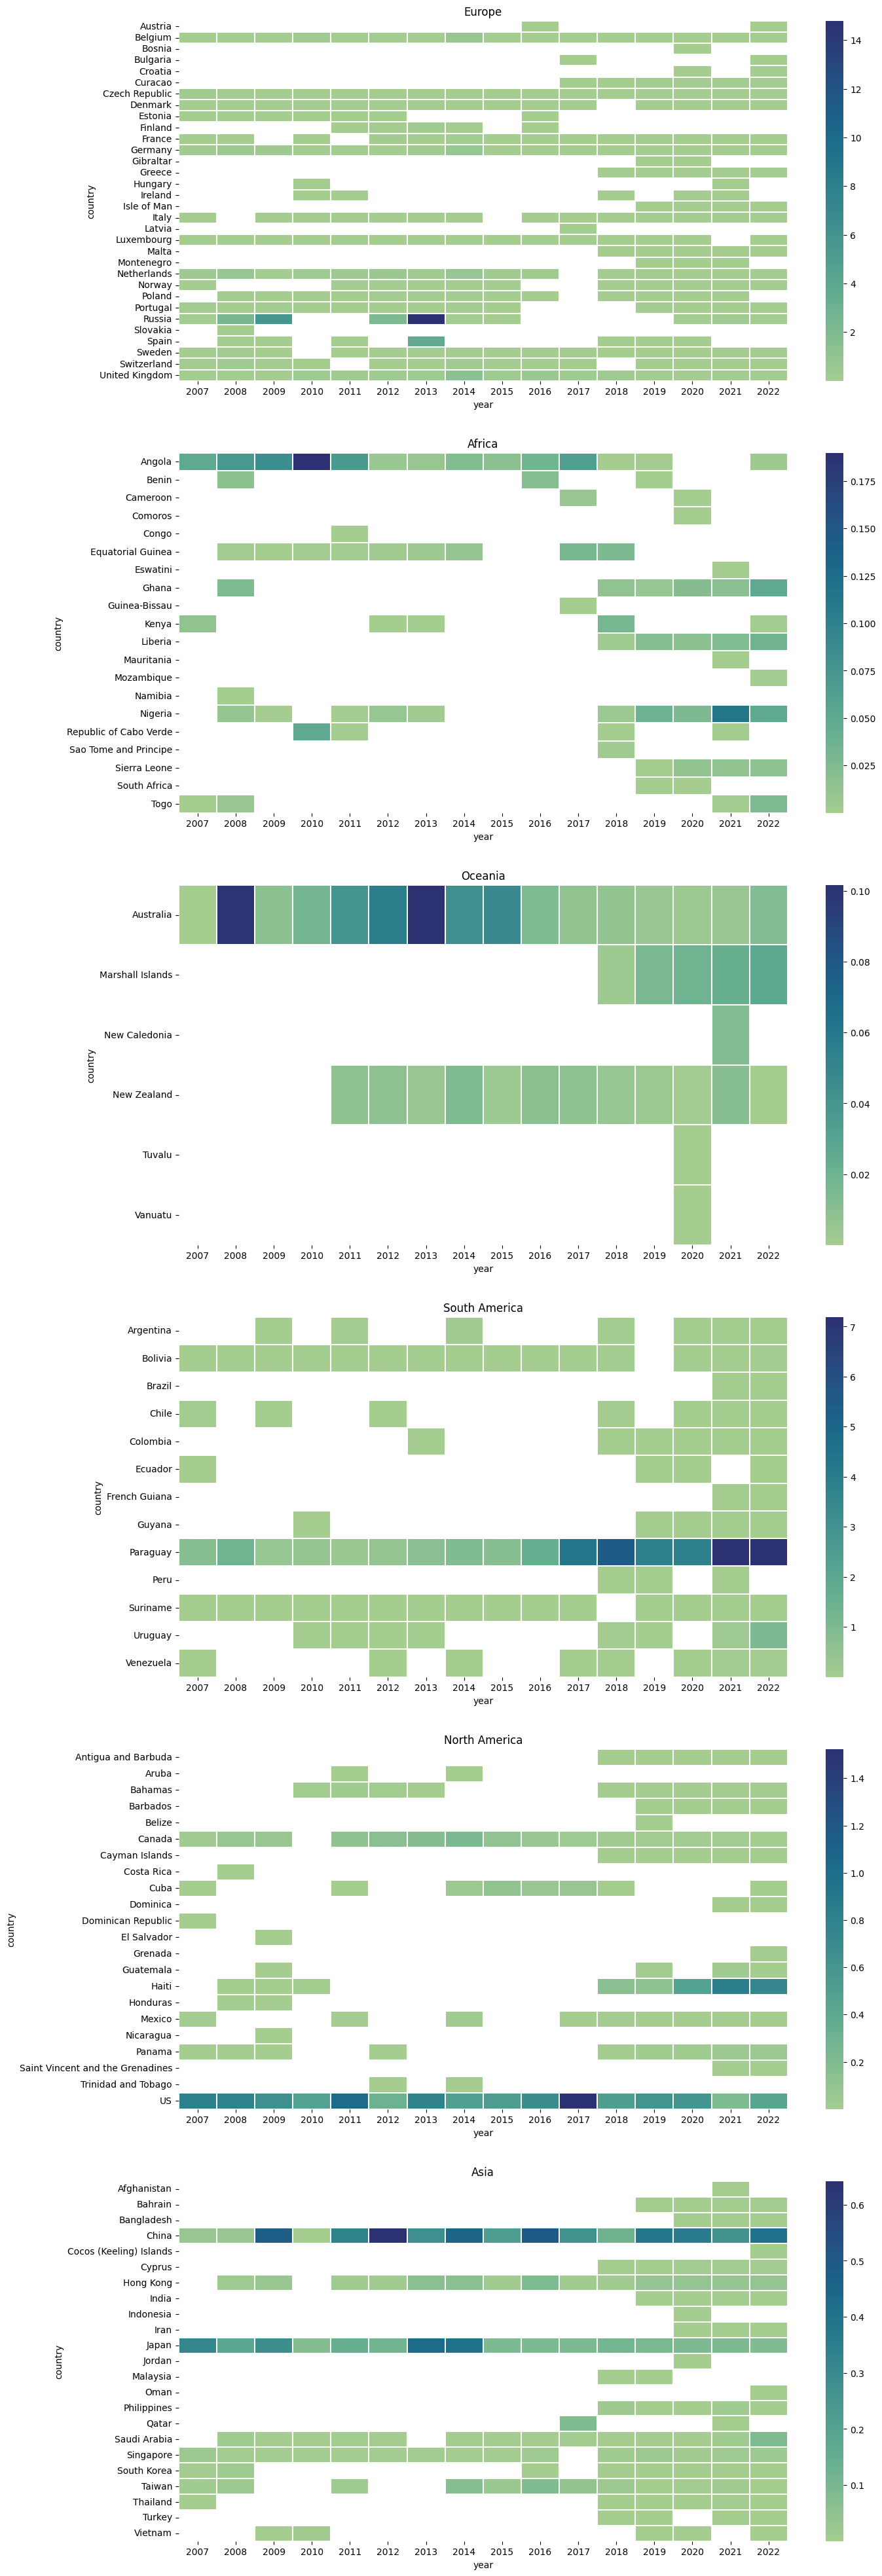

In [26]:
fig , axes = plt.subplots(6, figsize = (15, 50))
counter = 0
continents = df['continent'].unique()
for ax in axes:
    sales_by_year = df[df["continent"] == continents[counter]].groupby(["year", "country"])["value"].sum() / 1_000_000
    sales_by_year = sales_by_year.unstack().T
    sns.heatmap(sales_by_year, linewidths=.2 ,cmap="crest", ax=ax)
    ax.set_title(f"{continents[counter]}")
    ax.grid(False)
    counter += 1
    

### 4. What is the percentage of total sales by continent   

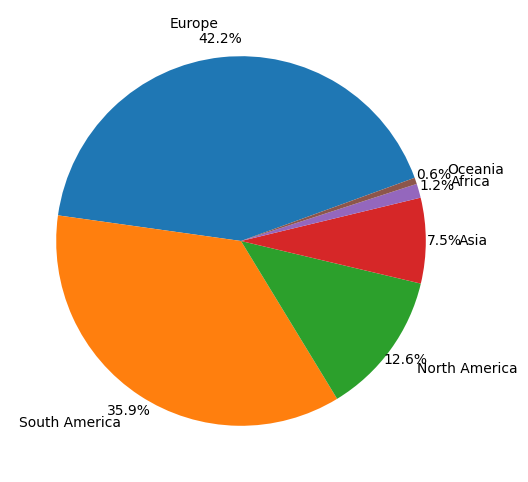

In [27]:
percentage_total = df.groupby(["continent"])["value"].sum() / df["value"].sum() * 100
percentage_total.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize = (6, 6))
ax.pie(percentage_total, labels=percentage_total.index, autopct='%1.1f%%', labeldistance=1.18, pctdistance=1.1, textprops={'fontsize': 10}, startangle=20);

## Steps on Quantity x Value Analysis

In [28]:
total_by_country = df.groupby(["country","continent"])[['quantity','value']].sum().sort_values(by='value', ascending=False)
total_by_country.reset_index(inplace=True)

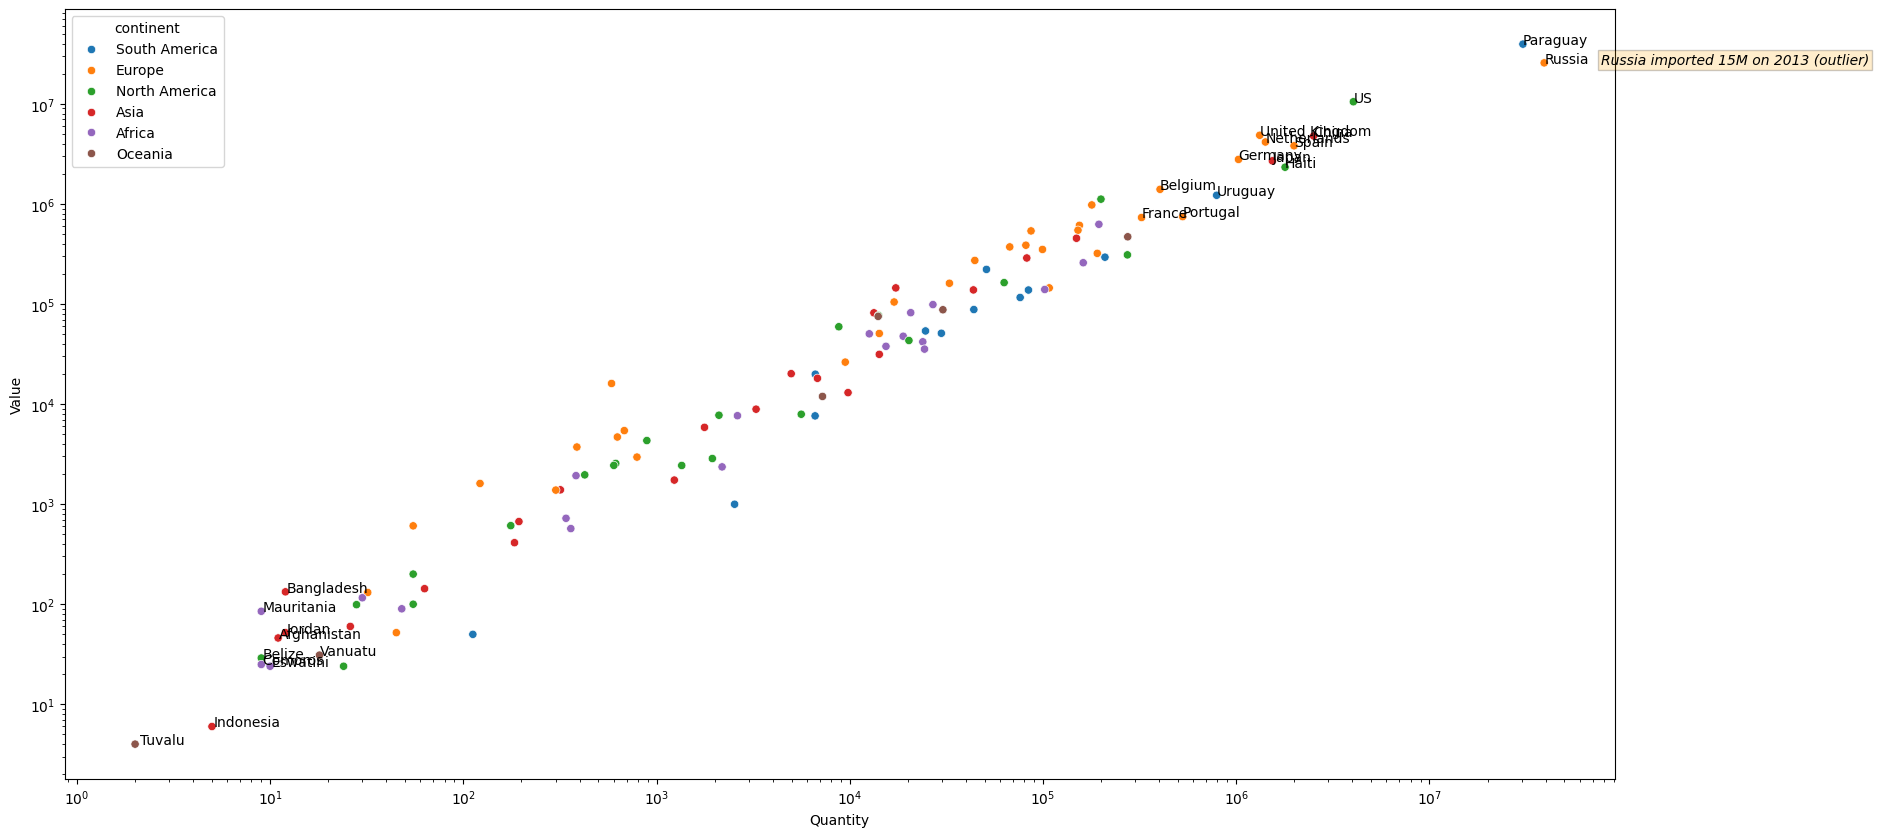

In [29]:
fig, ax = plt.subplots(figsize = (20, 10))
sales_by_country = df.groupby("country")["value"].sum() / 1_000_000
ax = sns.scatterplot(data=total_by_country, x="quantity", y="value", hue="continent", legend=True)
plt.xlabel('Quantity')
plt.ylabel('Value')
ax.set_xscale('log')
ax.set_yscale('log')
# plt.xticks(np.arange(0, 1, step=0.1), [0, 100, 200, 300, 400, 500, 600, 700, 800, 900])
#ax.set_yticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900])
#plt.grid(True, which='major', axis='x')

ax.text(77000000, 25000000, 'Russia imported 15M on 2013 (outlier)', style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.2, 'pad': 2})

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if point['x'] >= 300_000 or point['x'] <= 20:
            ax.text(point['x']+.12, point['y'], str(point['val']))

label_point(total_by_country.quantity, total_by_country.value, total_by_country.country, plt.gca()) 
plt.show();

### Value per Liter Analysis per year

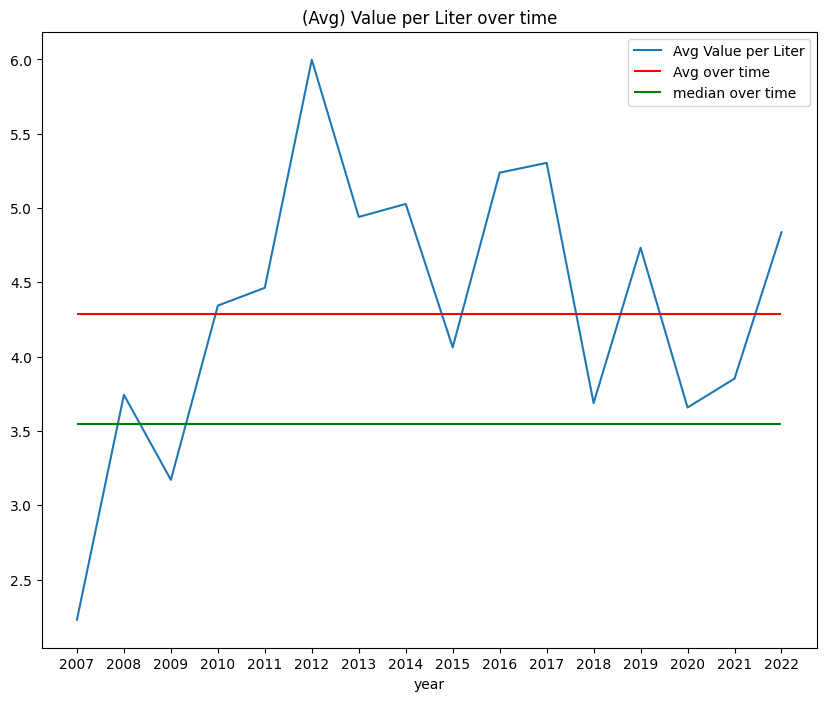

In [30]:
fig, ax = plt.subplots(figsize = (10, 8))
df.groupby("year")['value_x_liter'].mean().plot(label="Avg Value per Liter")
ax.set_title("(Avg) Value per Liter over time")
ax.set_xticks(df['year'].unique())
ax.hlines(df['value_x_liter'].mean(), df['year'].min(), df['year'].max(), color='red', label='Avg over time')
ax.hlines(df['value_x_liter'].median(), df['year'].min(), df['year'].max(), color='green', label='median over time')
ax.legend();

### Compare average total with top 5 countries

In [31]:
top_5_countries_by_value = df.groupby("country")["value"].sum().sort_values(ascending=False).head(5).index.to_list()
top_5_c_value_liter = df[["year", "country", "value_x_liter"]].loc[df["country"].isin(top_5_countries_by_value)]
top_5_c_value_liter = top_5_c_value_liter.pivot(index="year", columns="country", values="value_x_liter")
top_5_c_value_liter.fillna(0, inplace=True)

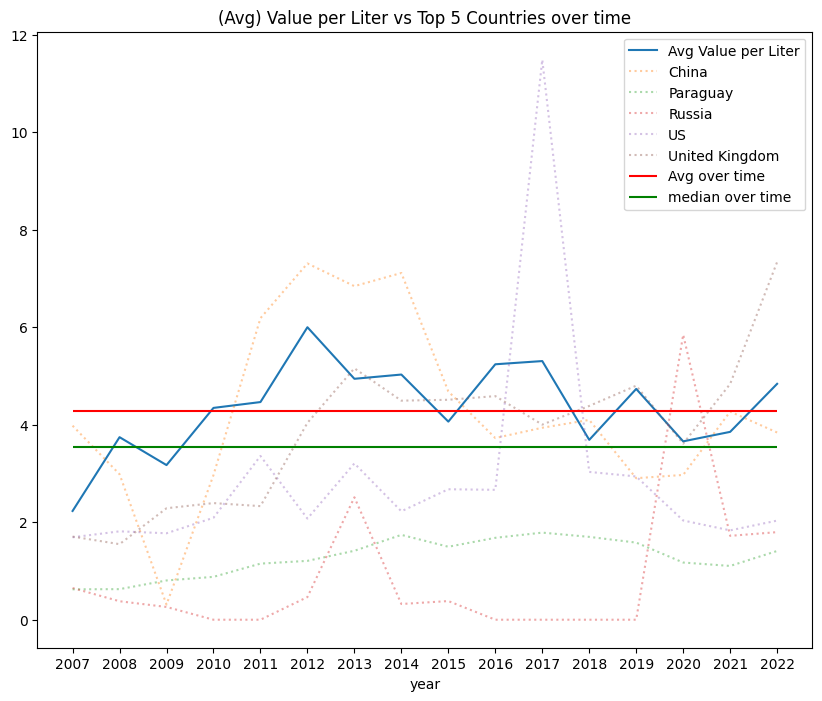

In [32]:
fig, ax = plt.subplots(figsize = (10, 8))
df.groupby("year")['value_x_liter'].mean().plot(label="Avg Value per Liter")
ax.plot(top_5_c_value_liter, alpha=0.4, label=top_5_c_value_liter.columns, linestyle=':')
ax.set_title("(Avg) Value per Liter vs Top 5 Countries over time")
ax.set_xticks(df['year'].unique())
ax.hlines(df['value_x_liter'].mean(), df['year'].min(), df['year'].max(), color='red', label='Avg over time')
ax.hlines(df['value_x_liter'].median(), df['year'].min(), df['year'].max(), color='green', label='median over time')
ax.legend();

### Compare average total with top 10 countries (boxplot)

In [33]:
df_value_liter = df[["year", "country", "value_x_liter"]]
df_value_liter = df_value_liter.pivot(index="year", columns="country", values="value_x_liter")
# df_value_liter.reset_index(inplace=True)

In [34]:
df_value_liter.fillna(0, inplace=True)

In [35]:
top_10_countries_by_value = df.groupby("country")["value"].sum().sort_values(ascending=False).head(10).index.to_list()

In [36]:
data_set = []
country_name = []
for c in top_10_countries_by_value:
    data_set.append(df_value_liter[c])
    country_name.append(f"{c}")
    

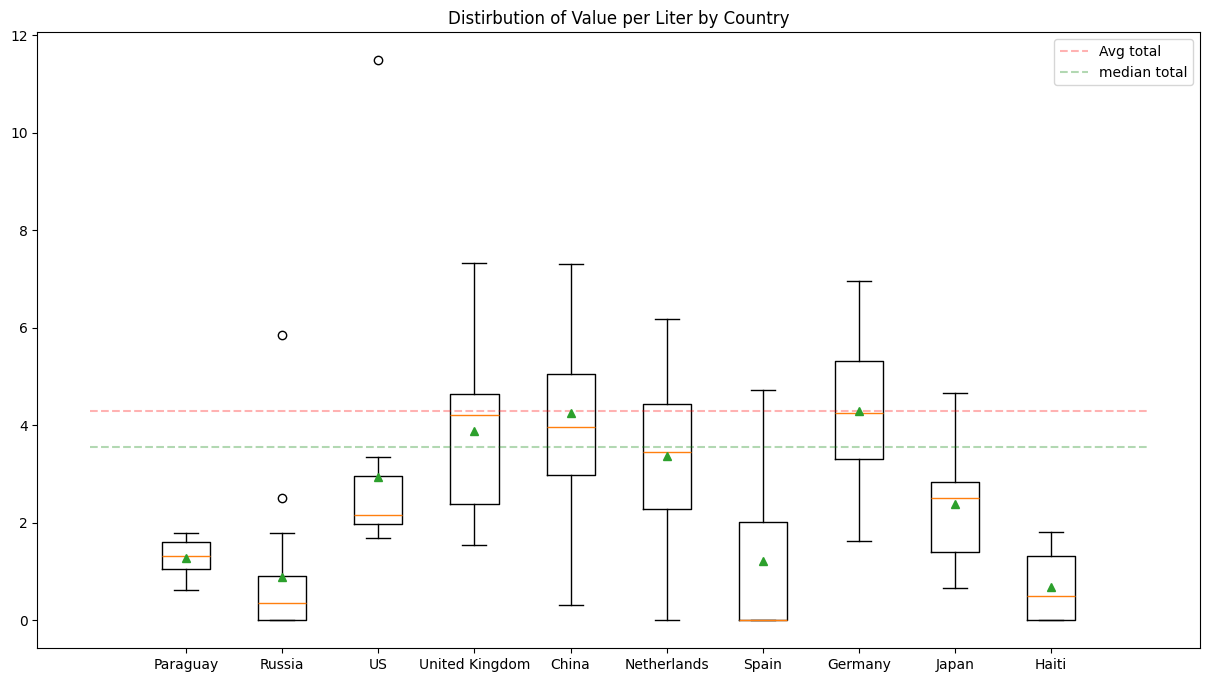

In [37]:
fig, ax = plt.subplots(figsize = (15, 8))
ax.boxplot(data_set, labels=country_name, showmeans=True)
ax.hlines(df['value_x_liter'].mean(), 0, len(top_10_countries_by_value)+1, color='red', label='Avg total', alpha=0.3, linestyles='--')
ax.hlines(df['value_x_liter'].median(), 0, len(top_10_countries_by_value)+1, color='green', label='median total', alpha=0.3, linestyles='--')
ax.legend()
ax.set_title("Distirbution of Value per Liter by Country")
plt.show()

# Results

```
Sales per Year. 
Vemos que não existe uma tendência clara nas exportaçoes globais no decorrer do tempo. Existe um alto pico em 2013
que podemos perceber no hearmap onde o pico é ocasionado por uma alta exportação a Rússia e também a Espanha. 
Pós 2015 podemos ver que a maior parte das exportaçoes em crescimento são dirigidas para America Latina. Onde vemos um grande crescimento
as exportaçoes feitas para o Paraguai.
Também podemos ver que em 2016 disminuimos as exportaçoes para paises como Australia, Nova zelandia, Canada e Japão (onde baixou, porem mantiveram uma média de entre $150.000-$200.000 em exportaçoes anuais)

Valor do Litro por quantidade exportada. 
Podemos observar que existe a tendencia global de quanto maior a quantidade exportada menor será o valor por litro. 
Porem, vemos que existem grandes picos de valores por litro na tendência anual que façem que a media fique bem mais alta que
a mediana de valor litro exportado. 
Quando olhamo no boxplot, vemos que os 10 paises onde mais exportamos eles mantem suas medias/medianas por baixo da media/mediana global
podemos ver também que por algum motivo US chegou a pagar quase $12 dolares o litro exportado em 2013 vendo que a sua variaçåo é das 
menores entre os 10 paises que mais importam o vinho. 

Para os inversores, a melhor opção sería analizar os mercados que perdemos exportação e entender o porque, para poder melhorar a exportação, abrangendo mais mercados e aumentando a quantidade exportada.
```